In [12]:
from helpers import *

k = 6
knum = 2

p = 50
n = 100
Z, M, B = create_factors(n, k, p, sig=.5, eps=.02, correlated=True)
# Z, _, _ = create_factors(n, k, p, sig=.5)
Z = normalize_columns(Z)

Zk, Theta_tru, svd_C = compute_k_truncated_svd(Z, k)

tsms_idx = tsms(Z, Zk, knum)
tsms_smin = smallest_singular_value(Z[:, tsms_idx])

_, Theta_hat = svd_convex_optimization(Z, .5*svd_C, knum)
sgl_idx = top_k_rows_indices(Theta_hat, knum)
sgl_smin = smallest_singular_value(Z[:, sgl_idx])

print(tsms_smin, sgl_smin)

0.01632258726751942 0.9899564131234035


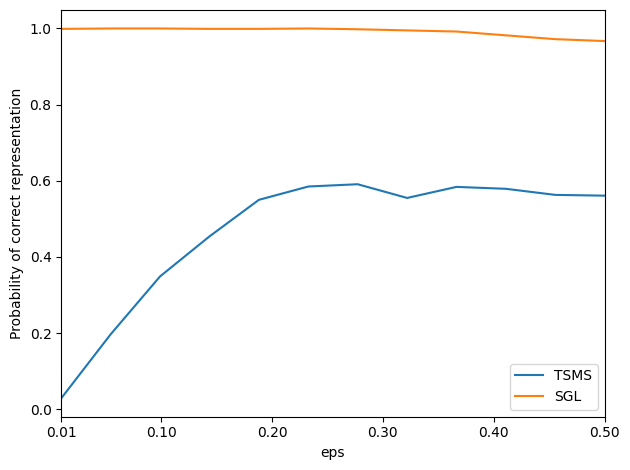

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import *

# ... [previous imports and setup code]

# set seed for reproducibility
np.random.seed(1)

eps_values = np.linspace(0.01, 0.5, 12)
nreps = 1000
results = []

for eps in eps_values:
    for rep in range(nreps):
        Z, M, B = create_factors(n, k, p, sig=.5, eps=eps, correlated=True)
        Z = normalize_columns(Z)
        Zk, Theta_tru, svd_C = compute_k_truncated_svd(Z, k)

        tsms_idx = tsms(Z, Zk, knum)
        tsms_smin = smallest_singular_value(Z[:, tsms_idx]) 

        _, Theta_hat = svd_convex_optimization(Z, .5*svd_C, knum)
        sgl_idx = top_k_rows_indices(Theta_hat, knum) 
        sgl_smin = smallest_singular_value(Z[:, sgl_idx]) 

        results.append({'rep': rep, 'method': 'tsms', 'smin': tsms_smin, 'eps': eps})
        results.append({'rep': rep, 'method': 'sgl', 'smin': sgl_smin, 'eps': eps})

df = pd.DataFrame(results)

# averages = df.groupby(['method', 'eps']).smin.mean().reset_index()
averages = df.groupby(['method', 'eps']).apply(lambda g: (g['smin'] > 0.5).mean()).reset_index()
averages = averages.rename(columns={0: 'fraction_smin_gt_0_5'})


for method in ['tsms', 'sgl']:
    subset = averages[averages.method == method]
    plt.plot(subset.eps, subset.fraction_smin_gt_0_5, label=method.upper())
    # plt.plot(subset.eps, subset.smin, label=method.upper())

plt.xlabel('eps')
# plt.ylabel(r'$s_{min}(\hat X)$')
plt.ylabel(r'Probability of correct representation')
plt.xticks(list(plt.xticks()[0]) + [eps_values[0]])  # Adding the minimum eps value to the ticks
plt.xlim(eps_values[0], eps_values[-1])  # Setting x-axis limits
plt.legend()
plt.tight_layout()  # Adjusts plot parameters for better layout
plt.savefig("smin_vs_eps.png", dpi=300)  # Saves the plot as a PNG file with 300 dpi resolution
plt.show()

# updated

In [13]:
from helpers import *


def create_factors(n, k, p, sig=1, rho=1, eps=0.5, correlated=False, knum=2):

    if correlated:
        # Create X as an n x k standard Gaussian matrix
        X = np.random.randn(n, knum)
        
        # Create a matrix whose columns are repeats of the first two columns k times
        X = np.hstack((X, np.repeat(X, k/knum - 1, axis=1))) + eps*np.random.randn(n, k)
    else:
        # Create X as an n x k standard Gaussian matrix
        X = np.random.randn(n, k)

    # Generate B with entries from a normal distribution with mean 0 and variance 1/k
    #B = np.random.randn(k, p-k) * np.sqrt(1/k) * np.sqrt(1 - sig**2)
    # Create B as a random k x (p-k) matrix
    B = np.random.randn(k, p-k)
    
    # Normalize B such that its l1 matrix norm is rho
    B = normalize(B, axis=0, norm='l2') * rho
    
    # Generate W as the noise matrix with entries from a normal distribution with mean 0 and variance sig^2
    W = sig * np.random.randn(n, p-k)

    # Calculate M2
    M2 = X @ B

    # Calculate Y
    Y = M2 + W

    # Calculate Z = [X  Y] (column concatenation of X and Y)
    Z = np.hstack((X, Y))

    # Create the mean matrix
    M = np.hstack((X, M2))

    return Z, M, B


def choose_factor(method, Z, Knum, train_size=600, svd_C = None, asset= [[None]], fix_true = None,fix_false = None,hyper_p = None):
   
    Z = Z[:train_size]
    Znorm = normalize_columns(Z)
    n, p = Z.shape
    # SVD Z and define the knum principal components
    Handssr = []
 
    if method == 'DGL':
        
        chosen_set =[]
        # Znorm = Z
        # knum_list = np.array([Knum-2,Knum-1,Knum,Knum+1,Knum+2])
        knum_list = np.array([Knum])
        # svd_C_list = np.linspace(0, svd_C, 10)
        svd_C_list = np.array([svd_C])

        SSR = 999
        final_knum = 0
        final_chosen_set = []
        knum_chosen_set = []
        cv_ssr = SSR-1
        final_svd_C  = 0
        for knum in knum_list:
            for svd_C_i in svd_C_list:
                if asset[0][0]:
                    asset = asset[:train_size]
                    asset = normalize_columns(asset)
                    asset_train,asset_test = train_test(asset,train_size*2//3)
                # St = sr_best(Znorm,lambda_val = 0.031, sigma = 500, T = 10000)
                Gammavalue = Z_convex_optimization(Znorm, svd_C_i, knum)[1]
                
                nonzero = np.count_nonzero(np.round(cp.norm(Gammavalue, 2, axis=1).value,6))
                
                if nonzero == 0:
                    pass
                elif  0<nonzero<knum :
                    # chosen_set,hand_ssr= chosen_set_with_press(Gammavalue,nonzero,Znorm_train,Znorm_test)
                    chosen_set,cv_ssr= chosen_set_with_press(Gammavalue,nonzero,Znorm)
                elif nonzero >= knum:
                    chosen_set,cv_ssr= chosen_set_with_press(Gammavalue,knum,Znorm)
               
                
                if cv_ssr<SSR:
                    SSR = cv_ssr
                    final_chosen_set =  chosen_set
                    final_knum = knum
                    final_svd_C = svd_C_i
                # print(knum,svd_C_i,cv_ssr,chosen_set)
                        
            
   
            if  len(knum_chosen_set)==0:
                knum_chosen_set = final_chosen_set
            elif len(final_chosen_set) > len(knum_chosen_set):
                union_set = list(set(final_chosen_set).union(knum_chosen_set))
                check_set = np.setdiff1d(range(p),union_set)
                check_press1 =np.mean([PRESS_statistic(Znorm[:,i],Znorm[:,final_chosen_set]) for i in check_set ])
                check_press2 = np.mean([PRESS_statistic(Znorm[:,i],Znorm[:,knum_chosen_set]) for i in check_set ])
                # print(final_chosen_set,'check_press1 ',check_press1 ,knum_chosen_set,'check_press2',check_press2 )
                if check_press1 < check_press2:
                    knum_chosen_set = final_chosen_set
       
        
          # print('knum',knum,knum_chosen_set)
        return [knum_chosen_set ,final_svd_C]
        # Zk, Theta_tru, svd_C_hand = compute_k_truncated_svd
    if method == 'SGL':
        # shuffle_list = list(range(p))
        # random.shuffle(shuffle_list)
        # Znorm = np.array([Znorm[:,i] for i in shuffle_list]).T
        chosen_set =[]
        Znorm_train,Znorm_test = train_test(Znorm,train_size*3//5)
        knum_list = np.array([Knum-2,Knum-1,Knum,Knum+1,Knum+2])
        # knum_list = np.array([Knum])
        svd_C_list = np.linspace(0, svd_C, 10)
        # svd_C_list = [svd_C]
        # knum_list = np.array([Knum])
        
        SSR = 999
        final_knum = 0
        final_chosen_set = []
        knum_chosen_set = []
        cv_ssr = SSR-1
        final_svd_C  = 0
        
      
        for knum in knum_list:
            for svd_C_i in svd_C_list:
                if asset[0][0]:
                    asset = asset[:train_size]
                    asset = normalize_columns(asset)
                    asset_train,asset_test = train_test(asset,train_size*2//3)
                    U = get_U(np.hstack((Znorm,asset)), knum)
                    # U_train = get_U(np.hstack((Znorm_train,asset_train)), knum)
                    # U_test = get_U(np.hstack((Znorm_test,asset_test)), knum)
                else:
                    U = get_U(Znorm, knum)
                    # U_train = get_U(Znorm_train,knum)
                    # U_test = get_U(Znorm_test,knum)
                
                Gammavalue = svd_convex_optimization(Znorm, svd_C_i, knum)[1]
                
                # Gammavalue = svd_convex_optimization(Znorm_train, svd_C_i, U_train, knum)
                ###########
                
                if fix_true:
                    Gammavalue[fix_true] = np.ones((knum))*100 
                if fix_false:
                    Gammavalue[fix_false] = np.zeros((knum)) 
                
                nonzero = np.count_nonzero(np.round(cp.norm(Gammavalue, 2, axis=1).value,4))
                if nonzero == 0:
                    pass
                elif  0<nonzero<knum :
                    # chosen_set,hand_ssr= chosen_set_with_press(Gammavalue,nonzero,Znorm_train,Znorm_test)
                    chosen_set,cv_ssr= chosen_set_with_press(Gammavalue,nonzero,Znorm)
                elif nonzero >= knum:
                    # reg = LinearRegression().fit(Znorm_train[:,[0,1,2,3,4]], Znorm_train[:,np.setdiff1d(range(p),[0,1,2,3,4])])
                    # Znorm_pred = reg.predict(Znorm_test[:,[0,1,2,3,4]])
                    # hand_ssr =sum(sum((Znorm_test[:,np.setdiff1d(range(p),[0,1,2,3,4])]-Znorm_pred)**2))/(p-5)
                    # print('[0,1,2,3,4]:', hand_ssr)
                    
                    
                    chosen_set,cv_ssr= chosen_set_with_press(Gammavalue,knum,Znorm)
                    # chosen_set,cv_ssr= chosen_set_with_press(Gammavalue,nonzero,Znorm)
                    
                    # chosen_set,hand_ssr=chosen_set_with_press(Gammavalue,nonzero,Znorm_train,Znorm_test)
                  
               
                # print('chosen_set',chosen_set,'cv_ssr',cv_ssr)
                
                    # print('knum',knum,chosen_set)
                if cv_ssr<SSR:
                    SSR = cv_ssr
                    final_chosen_set =  chosen_set
                   
                    final_knum = knum
                    final_svd_C = svd_C_i
                # print(knum,svd_C_i,cv_ssr,chosen_set)
                    # print('knum',final_knum,'by hand', SSR ,svd_C_i)
    # return SSR,final_chosen_set,final_knum,final_svd_C
            
            if  len(knum_chosen_set)==0:
                knum_chosen_set = final_chosen_set
            elif len(final_chosen_set) >= len(knum_chosen_set):
                union_set = list(set(final_chosen_set).union(knum_chosen_set))
                check_set = np.setdiff1d(range(p),union_set)
                check_press1 =np.mean([PRESS_statistic(Znorm[:,i],Znorm[:,final_chosen_set]) for i in check_set ])
                check_press2 = np.mean([PRESS_statistic(Znorm[:,i],Znorm[:,knum_chosen_set]) for i in check_set ])
                # print(final_chosen_set,'check_press1 ',check_press1 ,knum_chosen_set,'check_press2',check_press2 )
                if check_press1<check_press2:
                    knum_chosen_set = final_chosen_set
                # else:
                # # regret to last knum chosen_set and ssr
                #     SSR = np.mean([PRESS_statistic(Znorm[:,i],Znorm[:,knum_chosen_set]) for i in np.setdiff1d(range(p),knum_chosen_set)])
                #     final_chosen_set = knum_chosen_set 
                    
                # print('knum',knum,knum_chosen_set)
        return [knum_chosen_set ,final_svd_C]     


k = 4
knum = 2
p = 50
n = 100
Z, M, B = create_factors(n, k, p, sig=.5, eps=.02, correlated=True, knum=2)
# Z, _, _ = create_factors(n, k, p, sig=.5)
Z = normalize_columns(Z)

Zk, Theta_tru, svd_C = compute_k_truncated_svd(Z, knum)

tsms_idx = tsms(Z, Zk, knum)
tsms_smin = smallest_singular_value(Z[:, tsms_idx])

_, Theta_hat = svd_convex_optimization(Z, .5*svd_C, knum)
sgl_idx = top_k_rows_indices(Theta_hat, knum)
sgl_smin = smallest_singular_value(Z[:, sgl_idx])


dgl_idx= choose_factor('DGL', Z, knum, train_size=600, svd_C = compute_svd_C(Z,knum), asset=[[None]],fix_true = None,fix_false = None,hyper_p = 0.1)[0][:knum]
dgl_smin = smallest_singular_value(Z[:, dgl_idx]) 
print(dgl_idx,sgl_idx,tsms_idx)

[3, 0] [3 0] [3 1]


In [14]:
k = 4
knum = 2
p = 50
n = 100
# eps_values = np.linspace(0.01, 0.5, 12)
eps_values = [0.01]
nreps = 100
results = []
    
for eps in eps_values:
    print(eps)
    for rep in range(nreps):
    
        Z, M, B = create_factors(n, k, p, sig=.5, rho=1 ,eps=eps, correlated=True,knum=2)
        Z = normalize_columns(Z)
        Zk, Theta_tru, svd_C = compute_k_truncated_svd(Z, k)
        
        tsms_idx = tsms(Z, Zk, knum)
        tsms_smin = smallest_singular_value(Z[:, tsms_idx]) 

        _, Theta_hat = svd_convex_optimization(Z,3*eps*svd_C, knum)
        # _, Theta_hat = svd_convex_optimization(Z,4*eps*svd_C, knum)
        sgl_idx = top_k_rows_indices(Theta_hat, knum) 
        sgl_smin = smallest_singular_value(Z[:, sgl_idx]) 
        
        dgl_idx= choose_factor('DGL', Z, knum, train_size=600, svd_C = 0.8*compute_svd_C(Z,knum), asset=[[None]],fix_true = None,fix_false = None,hyper_p = 0.1)[0][:knum]
        dgl_smin = smallest_singular_value(Z[:, dgl_idx]) 
        print(dgl_idx,np.linalg.svd(Z[:, dgl_idx], compute_uv=False),sgl_idx,np.linalg.svd(Z[:, sgl_idx], compute_uv=False),tsms_idx,np.linalg.svd(Z[:, tsms_idx], compute_uv=False))
        
        
        results.append({'rep': rep, 'method': 'tsms', 'smin': tsms_smin,'idx': np.array(tsms_idx), 'eps': eps})
        results.append({'rep': rep, 'method': 'sgl', 'smin': sgl_smin,'idx': np.array(sgl_idx), 'eps': eps})
        results.append({'rep': rep, 'method': 'dgl', 'smin': dgl_smin, 'idx': np.array(dgl_idx),'eps': eps})

       

df = pd.DataFrame(results)


averages = df.groupby(['method', 'eps']).apply(lambda g: (g['smin'] > 0.5).mean()).reset_index()
averages = averages.rename(columns={0: 'fraction_smin_gt_0_5'})


print(averages)


# for method in ['tsms', 'sgl','dgl']:
#     subset = averages[averages.method == method]
#     plt.plot(subset.eps, subset.fraction_smin_gt_0_5, label=method.upper())
#     # plt.plot(subset.eps, subset.smin, label=method.upper())

# plt.xlabel('eps')
# # plt.ylabel(r'$s_{min}(\hat X)$')
# plt.ylabel(r'Probability of correct representation')
# plt.xticks(list(plt.xticks()[0]) + [eps_values[0]])  # Adding the minimum eps value to the ticks
# plt.xlim(eps_values[0], eps_values[-1])  # Setting x-axis limits
# plt.legend()
# plt.tight_layout()  # Adjusts plot parameters for better layout
# plt.savefig("smin_vs_eps.png", dpi=300)  # Saves the plot as a PNG file with 300 dpi resolution
# plt.show()

0.01


[1, 2] [1.00930719 0.99060537] [1 2] [1.00930719 0.99060537] [1 3] [1.41418441 0.00908042]
[1, 0] [1.00602963 0.99393379] [1 0] [1.00602963 0.99393379] [0 1] [1.00602963 0.99393379]
[1, 0] [1.05195377 0.94519483] [1 0] [1.05195377 0.94519483] [1 3] [1.41417534 0.01039765]
[3, 2] [1.02120173 0.97833891] [3 2] [1.02120173 0.97833891] [3 1] [1.41417311 0.01069603]
[2, 3] [1.01623247 0.98349965] [2 3] [1.01623247 0.98349965] [2 0] [1.41418129 0.00955391]
[2, 1] [1.00699735 0.99295335] [1 2] [1.00699735 0.99295335] [2 0] [1.41418198 0.00945088]
[2, 3] [1.00131712 0.99868114] [3 2] [1.00131712 0.99868114] [3 1] [1.4141878  0.00853687]
[3, 2] [1.02325977 0.97618617] [3 2] [1.02325977 0.97618617] [3 1] [1.41419096 0.0079961 ]
[3, 0] [1.02798562 0.97120831] [3 0] [1.02798562 0.97120831] [3 1] [1.41417997 0.00974757]
[1, 2] [1.05985666 0.93632465] [1 2] [1.05985666 0.93632465] [1 3] [1.41416377 0.01186768]
[2, 3] [1.05649633 0.94011463] [2 1] [1.05734855 0.93915602] [3 1] [1.41417334 0.01066602]

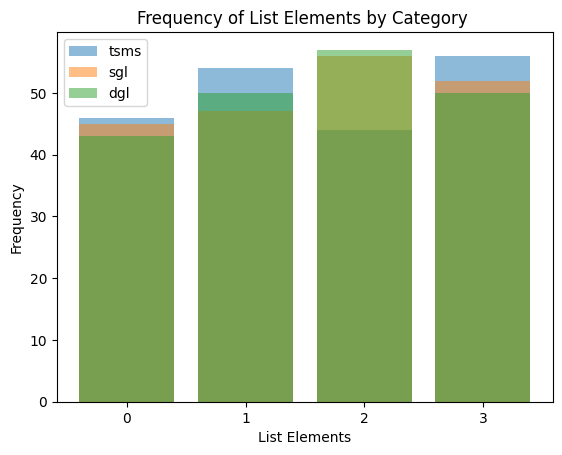

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 统计每个类别的频数
category_counts = df['method'].value_counts()

# 创建一个空字典，用于存储每个类别的频数
frequency_dict = {}

# 遍历DataFrame的每一行
for _, row in df.iterrows():
    category = row['method']
    lst = row['idx']
    
    # 统计每个列表中元素的频数
    for element in lst:
        frequency_dict[element] = frequency_dict.get(element, {category: 0})
        frequency_dict[element][category] = frequency_dict[element].get(category, 0) + 1

# 对键进行排序
sorted_keys = sorted(frequency_dict.keys())

# 提取每个类别的频数
category_frequencies = {category: [frequency_dict.get(element, {category: 0}).get(category, 0) for element in sorted_keys] for category in category_counts.index}
# 创建柱状图的x轴位置
x = range(len(sorted_keys))

# 绘制柱状图
for i, category in enumerate(category_counts.index):
    plt.bar(x, category_frequencies[category],  alpha=0.5, label=category)

# 设置x轴标签
plt.xticks(x, sorted_keys)

# 设置图例
plt.legend()

# 设置图表标题和轴标签
plt.title('Frequency of List Elements by Category ')
plt.xlabel('List Elements')
plt.ylabel('Frequency')

# 显示图表
plt.show()





In [17]:
df['odd_even'] = df.apply(lambda g: (g['idx']%knum),axis=1)
dff=df
set0=[]
for i in range(len(df.idx)):
    if set(df.idx[i]).issubset(list(range(k))):
        if len(set(df.odd_even[i]))==knum:
            df.odd_even[i] = 1
        else:
            df.odd_even[i] = 0
    else:
        print(i)
        set0.append(i)
df=df.drop(set0)
        
odd_even = df.groupby(['method', 'eps']).apply(lambda g: (g['odd_even']).mean()).reset_index()
odd_even= odd_even.rename(columns={0: 'prob'})
print(
    odd_even
)


  method   eps  prob
0    dgl  0.01  1.00
1    sgl  0.01  0.95
2   tsms  0.01  0.08


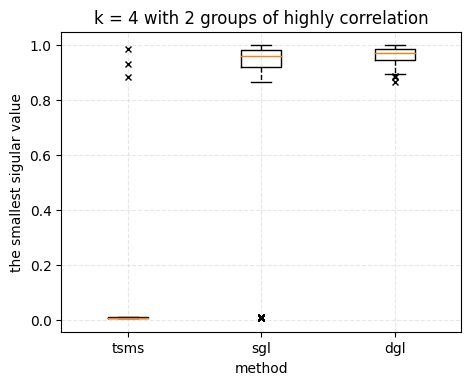

In [29]:
freq=[]
for method in category_counts.index:

    freq.append(list(df[df.method==method].smin))

fig = plt.figure(figsize =(4, 3))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
plt.xlabel('method')
plt.ylabel('the smallest sigular value')
plt.title('k = 4 with 2 groups of highly correlation')
plt.grid(linestyle="--", alpha=0.3)
# flierprops = dict(marker='x', markersize=5)
bp = ax.boxplot(freq, flierprops=flierprops,whiskerprops={'linestyle': '--'})
plt.xticks(range(1,len(category_counts.index)+1), category_counts.index)
# show plot
plt.show()

fig.savefig('boxplot_robust_4_2.pdf',dpi=600,format='pdf',bbox_inches="tight")


In [ ]:

for method in ['tsms', 'sgl','dgl']:
    subset = odd_even[odd_even.method == method]
    plt.plot(subset.eps, subset.prob, label=method.upper())
    # plt.plot(subset.eps, subset.smin, label=method.upper())

plt.xlabel('eps')
# plt.ylabel(r'$s_{min}(\hat X)$')
plt.ylabel(r'Probability of correct representation')
plt.xticks(list(plt.xticks()[0]) + [eps_values[0]])  # Adding the minimum eps value to the ticks
plt.xlim(eps_values[0], eps_values[-1])  # Setting x-axis limits
plt.legend()
plt.tight_layout()  # Adjusts plot parameters for better layout
plt.savefig("oddeven_vs_eps.png", dpi=300)  # Saves the plot as a PNG file with 300 dpi resolution
plt.show()

In [22]:
k = 6
p = 50
n = 100
knum=2
eps_values = [0.01]

nreps = 100
results = []
    
for eps in eps_values:
    print(eps)
    for rep in range(nreps):
    
        Z, M, B = create_factors(n, k, p, sig=.5, rho=1 ,eps=eps, correlated=True,knum=2)
        Z = normalize_columns(Z)
        Zk= compute_k_truncated_svd(Z, k)[0]
        svd_C= compute_k_truncated_svd(Z, knum)[-1]
        
        tsms_idx = tsms(Z, Zk, knum)
        tsms_smin = smallest_singular_value(Z[:, tsms_idx]) 

        _, Theta_hat = svd_convex_optimization(Z,3*eps*svd_C, knum)
        #_, Theta_hat = svd_convex_optimization(Z,1*eps*svd_C, knum) 2 10
        sgl_idx = top_k_rows_indices(Theta_hat, knum) 
        sgl_smin = smallest_singular_value(Z[:, sgl_idx]) 
        
        dgl_idx= choose_factor('DGL', Z, knum, train_size=600, svd_C = 1*compute_svd_C(Z,knum), asset=[[None]],fix_true = None,fix_false = None,hyper_p = 0.1)[0][:knum]
        dgl_smin = smallest_singular_value(Z[:, dgl_idx]) 
        print('dgl',dgl_idx,np.linalg.svd(Z[:, dgl_idx],'sgl', compute_uv=False),sgl_idx,np.linalg.svd(Z[:, sgl_idx], compute_uv=False),'tsms',tsms_idx,np.linalg.svd(Z[:, tsms_idx], compute_uv=False))
        
        
        results.append({'rep': rep, 'method': 'tsms', 'smin': tsms_smin,'idx': np.array(tsms_idx), 'eps': eps})
        results.append({'rep': rep, 'method': 'sgl', 'smin': sgl_smin,'idx': np.array(sgl_idx), 'eps': eps})
        results.append({'rep': rep, 'method': 'dgl', 'smin': dgl_smin, 'idx': np.array(dgl_idx),'eps': eps})

       
df = pd.DataFrame(results)


averages = df.groupby(['method', 'eps']).apply(lambda g: (g['smin'] > 0.5).mean()).reset_index()
averages = averages.rename(columns={0: 'fraction_smin_gt_0_5'})
print(averages)


# for method in ['tsms', 'sgl','dgl']:
#     subset = averages[averages.method == method]
#     plt.plot(subset.eps, subset.fraction_smin_gt_0_5, label=method.upper())
#     # plt.plot(subset.eps, subset.smin, label=method.upper())

# plt.xlabel('eps')
# # plt.ylabel(r'$s_{min}(\hat X)$')
# plt.ylabel(r'Probability of correct representation')
# plt.xticks(list(plt.xticks()[0]) + [eps_values[0]])  # Adding the minimum eps value to the ticks
# plt.xlim(eps_values[0], eps_values[-1])  # Setting x-axis limits
# plt.legend()
# plt.tight_layout()  # Adjusts plot parameters for better layout
# plt.savefig("smin_vs_eps.png", dpi=300)  # Saves the plot as a PNG file with 300 dpi resolution
# plt.show()

0.01
dgl [5, 2] [1.06030594 0.93581586] [3 5] [1.06059044 0.93549341] tsms [3 2] [1.41418289 0.00931462]
dgl [0, 1] [1.08260897 0.90992188] [1 0] [1.08260897 0.90992188] tsms [1 5] [1.41417604 0.01030188]
dgl [4, 3] [1.02931217 0.96980227] [3 4] [1.02931217 0.96980227] tsms [3 2] [1.41418489 0.00900505]
dgl [5, 3] [1.01310445 0.98672153] [4 1] [1.41418612 0.00881086] tsms [4 5] [1.41418215 0.00942552]


dgl [5, 2] [1.06526943 0.93016183] [5 0] [1.06545907 0.92994461] tsms [5 4] [1.41417277 0.01074176]
dgl [1, 0] [1.0099656  0.98993408] [2 1] [1.01049708 0.98939156] tsms [2 0] [1.41417231 0.01080184]
dgl [5, 2] [1.1202075  0.86321211] [5 4] [1.41418807 0.00849166] tsms [5 4] [1.41418807 0.00849166]
dgl [2, 4] [1.00522796 0.99474457] [2 4] [1.00522796 0.99474457] tsms [2 3] [1.41418038 0.00968746]
dgl [2, 4] [1.01523911 0.98452504] [4 2] [1.01523911 0.98452504] tsms [4 5] [1.41418617 0.00880226]
dgl [5, 2] [1.03230231 0.96661881] [5 4] [1.41419032 0.0081078 ] tsms [5 4] [1.41419032 0.0081078 ]
dgl [5, 0] [1.03517333 0.96354355] [5 4] [1.41418331 0.00925   ] tsms [4 5] [1.41418331 0.00925   ]
dgl [5, 2] [1.04539557 0.95244323] [2 5] [1.04539557 0.95244323] tsms [2 3] [1.41419121 0.00795091]
dgl [3, 4] [1.03317043 0.96569088] [3 1] [1.03362061 0.96520901] tsms [3 0] [1.41417721 0.01013934]
dgl [0, 4] [1.04056897 0.95771406] [3 4] [1.04050077 0.95778816] tsms [3 0] [1.41418884 0.00836177]


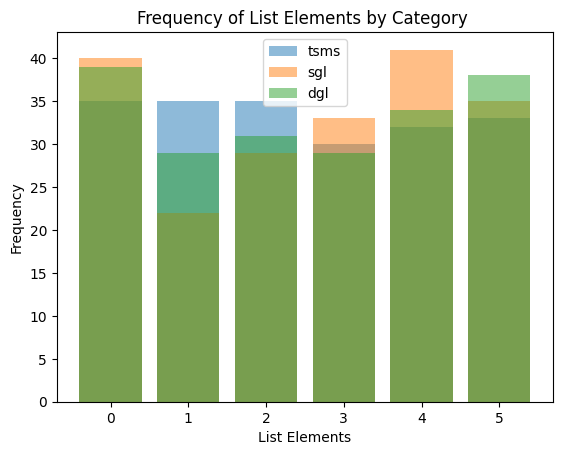

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 统计每个类别的频数
category_counts = df['method'].value_counts()

# 创建一个空字典，用于存储每个类别的频数
frequency_dict = {}

# 遍历DataFrame的每一行
for _, row in df.iterrows():
    category = row['method']
    lst = row['idx']
    
    # 统计每个列表中元素的频数
    for element in lst:
        frequency_dict[element] = frequency_dict.get(element, {category: 0})
        frequency_dict[element][category] = frequency_dict[element].get(category, 0) + 1

# 对键进行排序
sorted_keys = sorted(frequency_dict.keys())

# 提取每个类别的频数
category_frequencies = {category: [frequency_dict.get(element, {category: 0}).get(category, 0) for element in sorted_keys] for category in category_counts.index}
# 创建柱状图的x轴位置
x = range(len(sorted_keys))

# 绘制柱状图
for i, category in enumerate(category_counts.index):
    plt.bar(x, category_frequencies[category],  alpha=0.5, label=category)

# 设置x轴标签
plt.xticks(x, sorted_keys)

# 设置图例
plt.legend()

# 设置图表标题和轴标签
plt.title('Frequency of List Elements by Category ')
plt.xlabel('List Elements')
plt.ylabel('Frequency')

# 显示图表
plt.show()





In [103]:
df[df['method']=='tsms'] 

,rep,method,smin,idx,eps,odd_even
0,0,tsms,0.000010,"[5, 1]",0.00001,0
3,1,tsms,0.000009,"[4, 1]",0.00001,1
6,2,tsms,0.000010,"[0, 3]",0.00001,1
9,3,tsms,0.000010,"[1, 4]",0.00001,1
12,4,tsms,0.000010,"[1, 5]",0.00001,0
...,...,...,...,...,...,...
285,95,tsms,0.000009,"[5, 4]",0.00001,1
288,96,tsms,0.000011,"[4, 1]",0.00001,1
291,97,tsms,0.000012,"[2, 3]",0.00001,1
294,98,tsms,0.000011,"[3, 2]",0.00001,1


In [23]:

df['odd_even'] = df.apply(lambda g: (g['idx']%knum),axis=1)

set0=[]
for i in range(len(df.idx)):
    if set(df.idx[i]).issubset(list(range(k))):
        if len(set(df.odd_even[i]))==knum:
            df.odd_even[i] = 1
        else:
            df.odd_even[i] = 0
    else:
        print(i)
        set0.append(i)
        
df=df.drop(set0)  
odd_even = df.groupby(['method', 'eps']).apply(lambda g: (g['odd_even']).mean()).reset_index()
odd_even= odd_even.rename(columns={0: 'prob'})

print(odd_even)
# for method in ['tsms', 'sgl','dgl']:
#     subset = odd_even[odd_even.method == method]
#     plt.plot(subset.eps, subset.prob, label=method.upper())
#     # plt.plot(subset.eps, subset.smin, label=method.upper())

# plt.xlabel('eps')
# # plt.ylabel(r'$s_{min}(\hat X)$')
# plt.ylabel(r'Probability of correct representation')
# plt.xticks(list(plt.xticks()[0]) + [eps_values[0]])  # Adding the minimum eps value to the ticks
# plt.xlim(eps_values[0], eps_values[-1])  # Setting x-axis limits
# plt.legend()
# plt.tight_layout()  # Adjusts plot parameters for better layout
plt.savefig("oddeven_vs_eps.png", dpi=300)  # Saves the plot as a PNG file with 300 dpi resolution
plt.show()

  method   eps  prob
0    dgl  0.01  0.60
1    sgl  0.01  0.61
2   tsms  0.01  0.68


<Figure size 640x480 with 0 Axes>

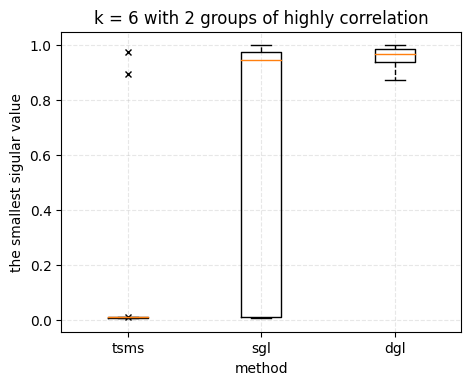

In [41]:
freq=[]
for method in category_counts.index:

    freq.append(list(df[df.method==method].smin))

fig = plt.figure(figsize =(4, 3))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
plt.xlabel('method')
plt.ylabel('the smallest sigular value')
plt.title('k = 6 with 2 groups of highly correlation')
plt.grid(linestyle="--", alpha=0.3)
# flierprops = dict(marker='x', markersize=5)
bp = ax.boxplot(freq, flierprops=flierprops,whiskerprops={'linestyle': '--'})
plt.xticks(range(1,len(category_counts.index)+1), category_counts.index)
# show plot
plt.show()

fig.savefig('boxplot_robust_6_2.pdf',dpi=600,format='pdf',bbox_inches="tight")


In [18]:
k = 6
p = 50
n = 100
knum=3
eps_values = [0.01]

nreps = 100
results = []
    
for eps in eps_values:
    print(eps)
    for rep in range(nreps):
    
        Z, M, B = create_factors(n, k, p, sig=.5, rho=1 ,eps=eps, correlated=True,knum=3)
        Z = normalize_columns(Z)
        Zk= compute_k_truncated_svd(Z, k)[0]
        svd_C = compute_k_truncated_svd(Z, k)[-1]
        
        tsms_idx = tsms(Z, Zk, knum)
        tsms_smin = smallest_singular_value(Z[:, tsms_idx]) 

        _, Theta_hat = svd_convex_optimization(Z,3*eps*svd_C, knum)
        #_, Theta_hat = svd_convex_optimization(Z,1*eps*svd_C, knum) 2 10
        sgl_idx = top_k_rows_indices(Theta_hat, knum) 
        sgl_smin = smallest_singular_value(Z[:, sgl_idx]) 
        
        dgl_idx= choose_factor('DGL', Z, knum, train_size=600, svd_C = 0.6*compute_svd_C(Z,knum), asset=[[None]],fix_true = None,fix_false = None,hyper_p = 0.1)[0][:knum]
        dgl_smin = smallest_singular_value(Z[:, dgl_idx]) 
        print('dgl',dgl_idx,np.linalg.svd(Z[:, dgl_idx],'sgl', compute_uv=False),sgl_idx,np.linalg.svd(Z[:, sgl_idx], compute_uv=False),'tsms',tsms_idx,np.linalg.svd(Z[:, tsms_idx], compute_uv=False))
        
        
        results.append({'rep': rep, 'method': 'tsms', 'smin': tsms_smin,'idx': np.array(tsms_idx), 'eps': eps})
        results.append({'rep': rep, 'method': 'sgl', 'smin': sgl_smin,'idx': np.array(sgl_idx), 'eps': eps})
        results.append({'rep': rep, 'method': 'dgl', 'smin': dgl_smin, 'idx': np.array(dgl_idx),'eps': eps})

       
df = pd.DataFrame(results)


averages = df.groupby(['method', 'eps']).apply(lambda g: (g['smin'] > 0.5).mean()).reset_index()
averages = averages.rename(columns={0: 'fraction_smin_gt_0_5'})
print(averages)


# for method in ['tsms', 'sgl','dgl']:
#     subset = averages[averages.method == method]
#     plt.plot(subset.eps, subset.fraction_smin_gt_0_5, label=method.upper())
#     # plt.plot(subset.eps, subset.smin, label=method.upper())

# plt.xlabel('eps')
# # plt.ylabel(r'$s_{min}(\hat X)$')
# plt.ylabel(r'Probability of correct representation')
# plt.xticks(list(plt.xticks()[0]) + [eps_values[0]])  # Adding the minimum eps value to the ticks
# plt.xlim(eps_values[0], eps_values[-1])  # Setting x-axis limits
# plt.legend()
# plt.tight_layout()  # Adjusts plot parameters for better layout
# plt.savefig("smin_vs_eps.png", dpi=300)  # Saves the plot as a PNG file with 300 dpi resolution
# plt.show()

0.01


dgl [0, 1, 5] [1.098935   0.9978755  0.89251687] [0 1 5] [1.098935   0.9978755  0.89251687] tsms [0 5 2] [1.41421497 0.9999561  0.00915532]
dgl [3, 5, 4] [1.07516771 1.02219478 0.89394196] [3 5 4] [1.07516771 1.02219478 0.89394196] tsms [3 0 5] [1.42834369 0.97966472 0.00955655]
dgl [4, 5, 3] [1.08731727 1.00384275 0.90002271] [4 5 0] [1.08718483 1.0039338  0.90008115] tsms [4 1 0] [1.41736859 0.99547132 0.01015524]
dgl [3, 2, 1] [1.06158299 1.03318126 0.89754   ] [3 2 1] [1.06158299 1.03318126 0.89754   ] tsms [2 3 5] [1.41723401 0.99566803 0.00963943]
dgl [3, 4, 2] [1.02712852 0.99783482 0.97433704] [3 5 4] [1.02692221 0.99801162 0.97437343] tsms [2 5 3] [1.41433255 0.99978109 0.01005989]
dgl [0, 4, 2] [1.05391319 0.99925364 0.94380038] [0 2 4] [1.05391319 0.99925364 0.94380038] tsms [0 3 2] [1.41417876 1.00000011 0.00991096]
dgl [4, 0, 5] [1.05727525 1.00380518 0.93517069] [4 5 0] [1.05727525 1.00380518 0.93517069] tsms [4 1 5] [1.41878826 0.9934554  0.00928706]
dgl [3, 5, 4] [1.115

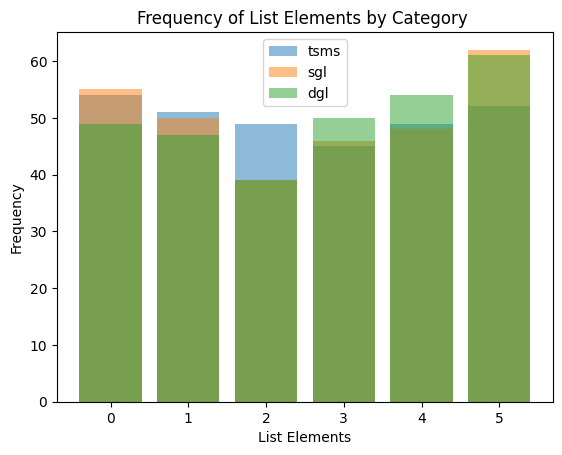

  method   eps  prob
0    dgl  0.01  0.99
1    sgl  0.01  0.98
2   tsms  0.01  0.00


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 统计每个类别的频数
category_counts = df['method'].value_counts()

# 创建一个空字典，用于存储每个类别的频数
frequency_dict = {}

# 遍历DataFrame的每一行
for _, row in df.iterrows():
    category = row['method']
    lst = row['idx']
    
    # 统计每个列表中元素的频数
    for element in lst:
        frequency_dict[element] = frequency_dict.get(element, {category: 0})
        frequency_dict[element][category] = frequency_dict[element].get(category, 0) + 1

# 对键进行排序
sorted_keys = sorted(frequency_dict.keys())

# 提取每个类别的频数
category_frequencies = {category: [frequency_dict.get(element, {category: 0}).get(category, 0) for element in sorted_keys] for category in category_counts.index}
# 创建柱状图的x轴位置
x = range(len(sorted_keys))

# 绘制柱状图
for i, category in enumerate(category_counts.index):
    plt.bar(x, category_frequencies[category],  alpha=0.5, label=category)

# 设置x轴标签
plt.xticks(x, sorted_keys)

# 设置图例
plt.legend()

# 设置图表标题和轴标签
plt.title('Frequency of List Elements by Category ')
plt.xlabel('List Elements')
plt.ylabel('Frequency')

# 显示图表
plt.show()

df['odd_even'] = df.apply(lambda g: (g['idx']%knum),axis=1)

set0=[]
for i in range(len(df.idx)):
    if set(df.idx[i]).issubset(list(range(k))):
        if len(set(df.odd_even[i]))==knum:
            df.odd_even[i] = 1
        else:
            df.odd_even[i] = 0
    else:

        set0.append(i)
        
df=df.drop(set0)  
odd_even = df.groupby(['method', 'eps']).apply(lambda g: (g['odd_even']).mean()).reset_index()
odd_even= odd_even.rename(columns={0: 'prob'})

print(odd_even)




In [ ]:
freq=[]
for method in category_counts.index:

    freq.append(list(df[df.method==method].smin))

fig = plt.figure(figsize =(4, 3))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
plt.xlabel('method')
plt.ylabel('the smallest sigular value')
plt.title('k = 6 with 2 groups of highly correlation')
plt.grid(linestyle="--", alpha=0.3)
# flierprops = dict(marker='x', markersize=5)
bp = ax.boxplot(freq, flierprops=flierprops,whiskerprops={'linestyle': '--'})
plt.xticks(range(1,len(category_counts.index)+1), category_counts.index)
# show plot
plt.show()

fig.savefig('boxplot_robust_6_3.pdf',dpi=600,format='pdf',bbox_inches="tight")
